In [8]:
import torch
# from encoder.encoders import DistributionEncoderTx
from encoder.wormhole_encoder import WormholeEncoder
from generator.wormhole import WormholeGenerator
from datasets.mnist import MNISTDataset
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
dataset = MNISTDataset(set_size=10, n_sets=10**4)

In [10]:
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
)

In [11]:
in_dim = 28*28
latent_dim = 64
hidden_dim = 128
set_size = dataset.set_size
device = 'cuda'

enc = WormholeEncoder(dataset.data[0][0].shape, latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-4)
enc.to(device)
gen.to(device)

hi!
data shape  784
out_dim 784


WormholeGenerator(
  (model): DistributionDecoderTx(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SELU()
      (2): SelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
    (multiplier): Linear(in_features=64, out_features=640, bias=True)
  )
)

In [12]:
for epoch in range(10):
    for idx,batch in enumerate(dataloader):
        
        samples = batch['samples'].to(device)
        latent = enc(samples)
        loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"epoch {epoch} batch {idx}: loss {loss.item()}")

epoch 0 batch 0: loss 37.72522735595703
epoch 0 batch 100: loss 10.195656776428223
epoch 0 batch 200: loss 8.096602439880371
epoch 0 batch 300: loss 8.265509605407715
epoch 1 batch 0: loss 7.811254024505615
epoch 1 batch 100: loss 7.867467880249023
epoch 1 batch 200: loss 6.954484462738037
epoch 1 batch 300: loss 6.9185309410095215
epoch 2 batch 0: loss 7.035782337188721
epoch 2 batch 100: loss 7.096721649169922
epoch 2 batch 200: loss 7.091353416442871
epoch 2 batch 300: loss 6.745758533477783
epoch 3 batch 0: loss 6.8786301612854
epoch 3 batch 100: loss 6.456361770629883
epoch 3 batch 200: loss 6.674504280090332
epoch 3 batch 300: loss 6.630125522613525
epoch 4 batch 0: loss 6.412708759307861
epoch 4 batch 100: loss 6.647007942199707
epoch 4 batch 200: loss 6.655275821685791
epoch 4 batch 300: loss 6.5052056312561035
epoch 5 batch 0: loss 6.1971940994262695
epoch 5 batch 100: loss 6.589249610900879
epoch 5 batch 200: loss 6.424038887023926
epoch 5 batch 300: loss 6.474335193634033
ep

In [6]:
enc.eval()
gen.eval()


Zs = []
labels = []
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        Zs += latent.cpu().tolist()
        labels += [b.item() for b in batch['metadata'].cpu()]
        

In [7]:
t = TSNE(n_components=2, random_state=0)
Zs = np.array(Zs)
Zs = t.fit_transform(Zs)

KeyboardInterrupt: 

In [ ]:
Zs.shape

(1000, 2)

<Axes: >

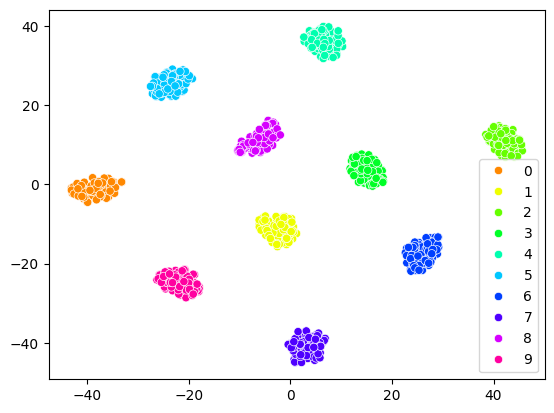

In [ ]:
sns.scatterplot(x=Zs[:, 0], y=Zs[:, 1], hue=labels, 
                palette=sns.color_palette("hsv", 10))

In [1]:
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        img = gen(latent).reshape(32, set_size, 28, 28)
        metadata = [b.item() for b in batch['metadata'].cpu()]

        print(metadata)

        plt.imshow(samples[1][0].cpu().reshape(28, 28))
        plt.show()

        plt.imshow(img[1][0].cpu())
        break

NameError: name 'torch' is not defined

In [1]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [2]:
hydra.initialize(config_path="config", version_base="1.1")

hydra.initialize()

In [3]:
cfg = hydra.compose(
    config_name='config',
    overrides=["experiment=mnist_multinomial",
                "encoder=wormhole_encoder",
                "generator=ddpm"]
)

In [4]:
encoder = hydra.utils.instantiate(cfg.encoder)
generator = hydra.utils.instantiate(cfg.generator)

In [6]:
cfg.generator

{'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}